In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from torch import tensor
import matplotlib.pyplot as plt

from mvl2.pyro import model, run
from mvl2 import genData2


In [4]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    # "PD_both": tensor(.005),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)


/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))
/home/akotlar/tada/project/mvl2/genData2.py:194: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  alt_counts = tensor(alt_counts)


In [5]:
sim_data["PVDs"].mean(0)

tensor([9.9243e-05, 1.2890e-04, 1.1543e-04, 1.5582e-04], dtype=torch.float64)

In [6]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([9.9997e-05, 9.9997e-05, 9.9997e-05, 9.9997e-05], dtype=torch.float64)
mean affects 1 tensor([9.8561e-05, 9.9584e-05, 1.9878e-04, 1.9878e-04], dtype=torch.float64)
std affects 1 tensor([9.6903e-05, 9.7906e-05, 1.9582e-04, 1.9582e-04], dtype=torch.float64)
mean affects 2 tensor([9.4720e-05, 3.0142e-04, 2.0108e-04, 6.2627e-04], dtype=torch.float64)
std affects 2 tensor([8.9165e-05, 2.9972e-04, 1.9943e-04, 6.6947e-04], dtype=torch.float64)
mean affects 3 tensor([9.6495e-05, 2.9600e-04, 9.8530e-05, 2.9600e-04], dtype=torch.float64)
std affects 3 tensor([0.0001, 0.0003, 0.0001, 0.0003], dtype=torch.float64)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


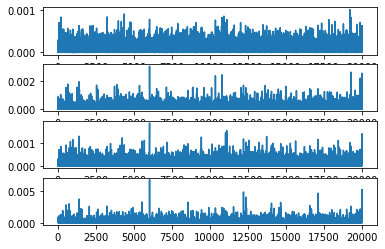

In [7]:
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [8]:
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PV = tensor(PV_mean).expand([n_genes,])
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


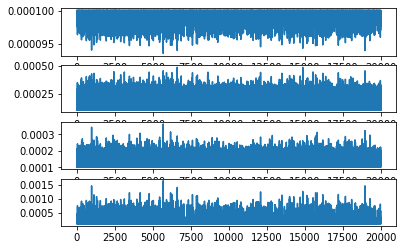

In [9]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [10]:
# run_params = {
#     "data": sim_data_point_pv["alt_counts"],
#     "n_cases": sim_params_point_pv["n_cases"],
#     "n_ctrls": sim_params_point_pv["n_ctrls"],
#     "max_tree_depth": 8,
#     "num_warmup": 200,
#     "num_samples": 1000,
#     "num_chains": 1,
#     "max_K": 12,
#     "chain_method": 'parallel',
#     "model_to_run": model,
# }


In [37]:
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = torch.tensor(np.array([0.04295,0.043475,0.012475]))
pd_with_both = torch.tensor(np.array([1 - pds.sum(), *pds]))
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = torch.tensor(df.to_numpy())
stat_data_dave

run_params = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model,
}

In [38]:
sim_params_point_pv["n_cases"] / (sim_params_point_pv["n_cases"].sum() + sim_params_point_pv["n_ctrls"])

tensor([0.1786, 0.1786, 0.0476])

In [39]:
from typing import Any, Tuple, Optional

import datetime
import os
import copy
import multiprocessing
import uuid

import torch
import numpy as np
import dill

import pyro
from pyro.distributions import Exponential
from pyro.distributions.torch import Multinomial, Beta, Dirichlet, Beta, Categorical, MultivariateNormal, Uniform#, Exponential #, HalfCauchy, LKJCholesky
from pyro.infer import TraceEnum_ELBO, TraceGraph_ELBO, MCMC, NUTS, TraceGraph_ELBO, config_enumerate#, #HMCECS, MixedHMC
from torch import tensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiscreteParallel
import pyro.poutine as poutine

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(0)

def set_platform(platform: str = "cpu") -> None:
    pyro.set_platform(platform)

def get_pdhat(n_cases: tensor, n_ctrls: int):
    samplePDs = n_cases.float() / (n_cases.float().sum() + float(n_ctrls))
    return tensor([1.0 - samplePDs.sum(), *samplePDs])


def get_expected_K(sampleCategories: int):
    # mu_exp, var_exp = get_log_params(liabParams55cov["afMean"].numpy(), 1)
    # Expected number of components
    # For 2 case types it's
    # none, 1only, 2only, both
    # For 3 it's
    # none, 1only, 2only, 3only, 1&2, 1&3, 2&3, 123 (7)
    # for 4 it's
    # none, 1only, 2only, 3only, 4only, 1&2, 1&3, 1&4, 2&3, 2&4, 3&4, 123, 124, 134, 234, 1234
    # which is 4 + 4choose2 + nchoose3  + nchoose4
    pass


def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

# Covariates needed
# Sex of the individual
# parent of origin would be important
def model1(data, n_cases: tensor, n_ctrls: tensor, k_hypotheses: tensor, alpha: float = .05):
    with pyro.plate("beta_plate", k_hypotheses-1):
        beta = pyro.sample("beta", Beta(1, alpha / k_hypotheses))

    pd_hat = get_pdhat(n_cases, n_ctrls)
    with pyro.plate("prob_plate", k_hypotheses):
        print("k_hypotheses", k_hypotheses)
        probs = pyro.sample("probs", Dirichlet(pd_hat))
        print(probs.shape)
        print(probs)

    with pyro.plate("data", data.shape[0]):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        return pyro.sample("obs", Multinomial(probs=probs[z], validate_args=False), obs=data)

def run1(run_params, folder_prefix: str = "") -> Tuple[MCMC, Tuple]:
    print(type(run_params['data']))
    # mcmc = infer(**run_params)
    optim = Adam({"lr": 0.05})
    guide = AutoDelta(poutine.block(model1, hide=['z']))

    svi = SVI(model1, guide, optim, loss=TraceGraph_ELBO())
    losses = []
    def train(num_iterations):
        pyro.clear_param_store()
        for j in tqdm(range(num_iterations)):
            loss = svi.step(run_params['data'].type(torch.DoubleTensor), run_params['n_cases'].double(), run_params['n_ctrls'].double(), float(run_params['max_K']))
            losses.append(loss)

    # def truncate(alpha, weights):
    #     threshold = alpha**-1 / 100.
    #     # true_centers = centers[weights > threshold]
    #     true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    #     return true_weights

    # alpha = 0.1
    train(1000)
    return losses, svi

In [40]:
losses, svi = run1(run_params=run_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/akotlar/miniconda3/lib/python3.8/site-packages/pyro/util.py:293: UserWarning: Found vars in model but not guide: {'z'}
  warnings.warn(
  1%|          | 8/1000 [00:00<00:13, 70.99it/s]

<class 'torch.Tensor'>
torch.Size([50, 4])
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 

  2%|▎         | 25/1000 [00:00<00:12, 76.21it/s]

torch.Size([50, 4])
tensor([[0.5863, 0.1381, 0.1381, 0.1375],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.6102, 0.1299, 0.1299, 0.1300],
        [0.610

  4%|▍         | 45/1000 [00:00<00:11, 83.93it/s]

torch.Size([50, 4])
tensor([[0.8296, 0.0579, 0.0577, 0.0548],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.9265, 0.0245, 0.0244, 0.0246],
        [0.926

  6%|▋         | 65/1000 [00:00<00:10, 87.80it/s]

torch.Size([50, 4])
tensor([[0.8910, 0.0387, 0.0383, 0.0320],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.9923, 0.0025, 0.0025, 0.0026],
        [0.992

  8%|▊         | 84/1000 [00:00<00:10, 87.09it/s]

torch.Size([50, 4])
tensor([[8.9986e-01, 3.7337e-02, 3.6735e-02, 2.6069e-02],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e-04],
        [9.9921e-01, 2.6321e-04, 2.6313e-04, 2.6778e

 10%|█         | 103/1000 [00:01<00:10, 88.25it/s]

torch.Size([50, 4])
tensor([[8.9745e-01, 3.9724e-02, 3.8877e-02, 2.3952e-02],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e-05],
        [9.9990e-01, 3.3071e-05, 3.3059e-05, 3.3758e

 12%|█▏        | 121/1000 [00:01<00:10, 86.26it/s]

torch.Size([50, 4])
tensor([[8.9474e-01, 4.1831e-02, 4.0832e-02, 2.2593e-02],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e-06],
        [9.9999e-01, 4.3997e-06, 4.3980e-06, 4.5025e

 14%|█▍        | 139/1000 [00:01<00:10, 82.46it/s]

torch.Size([50, 4])
tensor([[8.9399e-01, 4.2786e-02, 4.1744e-02, 2.1481e-02],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e-07],
        [1.0000e+00, 6.0917e-07, 6.0890e-07, 6.2465e

 15%|█▍        | 148/1000 [00:01<00:10, 79.03it/s]

torch.Size([50, 4])
tensor([[8.9431e-01, 4.3014e-02, 4.1983e-02, 2.0694e-02],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e-07],
        [1.0000e+00, 1.0762e-07, 1.0757e-07, 1.1051e

 17%|█▋        | 168/1000 [00:01<00:09, 84.65it/s]

torch.Size([50, 4])
tensor([[8.9479e-01, 4.3071e-02, 4.2058e-02, 2.0081e-02],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e-08],
        [1.0000e+00, 1.7379e-08, 1.7370e-08, 1.7870e

 19%|█▊        | 187/1000 [00:02<00:09, 87.21it/s]

torch.Size([50, 4])
tensor([[8.9510e-01, 4.3135e-02, 4.2133e-02, 1.9628e-02],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e-09],
        [1.0000e+00, 2.3044e-09, 2.3032e-09, 2.3727e

 21%|██        | 206/1000 [00:02<00:08, 88.72it/s]

torch.Size([50, 4])
tensor([[8.9523e-01, 4.3210e-02, 4.2212e-02, 1.9346e-02],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e-10],
        [1.0000e+00, 3.1002e-10, 3.0985e-10, 3.1957e

 22%|██▎       | 225/1000 [00:02<00:08, 89.35it/s]

torch.Size([50, 4])
tensor([[8.9530e-01, 4.3261e-02, 4.2263e-02, 1.9179e-02],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e-11],
        [1.0000e+00, 4.6849e-11, 4.6824e-11, 4.8338e

 24%|██▍       | 243/1000 [00:02<00:08, 89.33it/s]

torch.Size([50, 4])
tensor([[8.9535e-01, 4.3289e-02, 4.2292e-02, 1.9071e-02],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e-12],
        [1.0000e+00, 6.4334e-12, 6.4298e-12, 6.6438e

 26%|██▋       | 263/1000 [00:03<00:08, 90.00it/s]

torch.Size([50, 4])
tensor([[8.9538e-01, 4.3304e-02, 4.2307e-02, 1.9008e-02],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e-13],
        [1.0000e+00, 8.9047e-13, 8.8996e-13, 9.2033e

 28%|██▊       | 282/1000 [00:03<00:08, 87.93it/s]

torch.Size([50, 4])
tensor([[8.9540e-01, 4.3312e-02, 4.2316e-02, 1.8973e-02],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e-13],
        [1.0000e+00, 1.2408e-13, 1.2401e-13, 1.2834e

 30%|███       | 300/1000 [00:03<00:07, 88.93it/s]

torch.Size([50, 4])
tensor([[8.9541e-01, 4.3317e-02, 4.2321e-02, 1.8955e-02],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e-14],
        [1.0000e+00, 1.9282e-14, 1.9270e-14, 1.9955e

 32%|███▏      | 320/1000 [00:03<00:07, 90.02it/s]

torch.Size([50, 4])
tensor([[8.9541e-01, 4.3319e-02, 4.2323e-02, 1.8946e-02],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e-15],
        [1.0000e+00, 2.7150e-15, 2.7133e-15, 2.8116e

 34%|███▍      | 340/1000 [00:03<00:07, 89.36it/s]

torch.Size([50, 4])
tensor([[8.9541e-01, 4.3321e-02, 4.2324e-02, 1.8941e-02],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e-16],
        [1.0000e+00, 4.2554e-16, 4.2528e-16, 4.4093e

 36%|███▌      | 358/1000 [00:04<00:07, 86.01it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8939e-02],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e-17],
        [1.0000e+00, 6.0401e-17, 6.0364e-17, 6.2618e

 38%|███▊      | 377/1000 [00:04<00:07, 88.03it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e-17],
        [1.0000e+00, 1.0560e-17, 1.0553e-17, 1.0953e

 40%|███▉      | 396/1000 [00:04<00:06, 89.40it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e-18],
        [1.0000e+00, 1.5082e-18, 1.5072e-18, 1.5650e

 42%|████▏     | 416/1000 [00:04<00:06, 85.70it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e-19],
        [1.0000e+00, 2.1599e-19, 2.1586e-19, 2.2423e

 43%|████▎     | 426/1000 [00:04<00:06, 87.05it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e-20],
        [1.0000e+00, 3.8037e-20, 3.8012e-20, 3.9501e

 44%|████▍     | 445/1000 [00:05<00:06, 88.64it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e-21],
        [1.0000e+00, 5.4723e-21, 5.4688e-21, 5.6853e

 46%|████▋     | 463/1000 [00:05<00:06, 86.90it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e-22],
        [1.0000e+00, 8.7358e-22, 8.7301e-22, 9.0789e

 48%|████▊     | 481/1000 [00:05<00:06, 86.36it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e-22],
        [1.0000e+00, 1.5466e-22, 1.5456e-22, 1.6079e

 50%|█████     | 501/1000 [00:05<00:05, 88.36it/s]

tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.0000e+00, 2.4770e-23, 2.4753e-23, 2.5759e-23],
        [1.000

 52%|█████▏    | 519/1000 [00:05<00:05, 85.38it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e-24],
        [1.0000e+00, 3.9727e-24, 3.9701e-24, 4.1326e

 54%|█████▎    | 537/1000 [00:06<00:05, 85.81it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e-25],
        [1.0000e+00, 6.3805e-25, 6.3762e-25, 6.6392e

 56%|█████▌    | 555/1000 [00:06<00:05, 85.49it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e-25],
        [1.0000e+00, 1.0261e-25, 1.0254e-25, 1.0680e

 57%|█████▋    | 573/1000 [00:06<00:05, 83.01it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e-26],
        [1.0000e+00, 1.8283e-26, 1.8271e-26, 1.9035e

 59%|█████▉    | 591/1000 [00:06<00:04, 84.38it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e-27],
        [1.0000e+00, 3.6091e-27, 3.6066e-27, 3.7582e

 61%|██████    | 609/1000 [00:07<00:04, 81.24it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e-28],
        [1.0000e+00, 5.8221e-28, 5.8181e-28, 6.0641e

 62%|██████▏   | 618/1000 [00:07<00:04, 78.66it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e-28],
        [1.0000e+00, 1.1512e-28, 1.1504e-28, 1.1993e

 63%|██████▎   | 634/1000 [00:07<00:04, 75.96it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e-29],
        [1.0000e+00, 2.5207e-29, 2.5189e-29, 2.6265e

 65%|██████▌   | 651/1000 [00:07<00:04, 77.15it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e-30],
        [1.0000e+00, 5.5226e-30, 5.5187e-30, 5.7555e

 67%|██████▋   | 667/1000 [00:07<00:04, 75.43it/s]

tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.0000e+00, 1.0942e-30, 1.0934e-30, 1.1405e-30],
        [1.000

 68%|██████▊   | 683/1000 [00:08<00:04, 75.57it/s]

tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.0000e+00, 2.4000e-31, 2.3983e-31, 2.5021e-31],
        [1.000

 70%|██████▉   | 699/1000 [00:08<00:04, 74.94it/s]

tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.0000e+00, 5.2672e-32, 5.2634e-32, 5.4922e-32],
        [1.000

 72%|███████▏  | 716/1000 [00:08<00:03, 77.14it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e-32],
        [1.0000e+00, 1.0454e-32, 1.0446e-32, 1.0902e

 73%|███████▎  | 734/1000 [00:08<00:03, 82.11it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e-33],
        [1.0000e+00, 2.0759e-33, 2.0744e-33, 2.1653e

 75%|███████▌  | 752/1000 [00:08<00:03, 81.41it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e-34],
        [1.0000e+00, 3.3701e-34, 3.3676e-34, 3.5158e

 77%|███████▋  | 771/1000 [00:09<00:02, 85.09it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e-35],
        [1.0000e+00, 6.0560e-35, 6.0516e-35, 6.3189e

 78%|███████▊  | 780/1000 [00:09<00:02, 84.54it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e-35],
        [1.0000e+00, 9.8432e-36, 9.8360e-36, 1.0272e

 80%|███████▉  | 798/1000 [00:09<00:02, 85.07it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e-36],
        [1.0000e+00, 1.6008e-36, 1.5996e-36, 1.6708e

 82%|████████▏ | 817/1000 [00:09<00:02, 86.55it/s]

tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.0000e+00, 2.8811e-37, 2.8790e-37, 3.0076e-37],
        [1.000

 84%|████████▎ | 836/1000 [00:09<00:01, 88.12it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e-38],
        [1.0000e+00, 4.2404e-38, 4.2372e-38, 4.4272e

 85%|████████▌ | 853/1000 [00:10<00:01, 84.87it/s]

torch.Size([50, 4])
tensor([[8.9542e-01, 4.3321e-02, 4.2325e-02, 1.8938e-02],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e-39],
        [1.0000e+00, 6.9067e-39, 6.9014e-39, 7.2119e

ValueError: Error while computing log_prob at site 'probs':
Expected value argument (Tensor of shape (50, 4)) to be within the support (Simplex()) of the distribution Dirichlet(concentration: torch.Size([50, 4])), but found invalid values:
tensor([[0.8954, 0.0433, 0.0423, 0.0189],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan]], grad_fn=<ExpandBackward0>)
Trace Shapes:       
 Param Sites:       
Sample Sites:       
    beta dist 49 |  
        value 49 |  
     log_prob 49 |  
   probs dist 50 | 4
        value 50 | 4

In [102]:
max(losses)

133410.9375

In [16]:
mcmc, inferred_params = run(sim_data=sim_data_point_pv, run_params=run_params)

NameError: name 'numpyro' is not defined

In [14]:
data = run_params['data']
n_cases = run_params['n_cases']
n_ctrls = run_params['n_ctrls']
max_K = run_params['max_K']

guide = AutoNormal(model)
svi = SVI(model, guide, optim.Adam(0.01), TraceGraph_ELBO())
svi_state = svi.init(random.PRNGKey(0), data, n_cases, n_ctrls, max_K)
svi_result = svi.run(random.PRNGKey(1), 1000)
guide_samples = guide.sample_posterior(random.PRNGKey(2), svi_result.params)
guide_samples

ValueError: Continuous inference cannot handle discrete sample site 'z'.